In [6]:
import networkx as nx
import numpy as np
import pickle as p
from os import path
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib import pyplot as plt
%matplotlib inline
import torch

data_loc = 'C:/Users/alex_/Fac/M2/M2/S2/Discrete_Graphs/Projet/Data/BlogCatalog3/BlogCatalog-dataset/data/'

## Load Data

In [7]:
def load_data():
    iid = {}
    idx = 0
    edgelist = []

    # Read edges pairs
    with open(data_loc+'edges.csv', 'r') as f:
        for line in f.readlines():
            i, j = line.strip().split(',')  # csv
            if i not in iid:
                iid[i] = idx; idx += 1
            if j not in iid:
                iid[j] = idx; idx += 1
            edgelist.append((iid[i], iid[j]))

    # Create an nx undirected network
    bc = nx.Graph(edgelist)

    print("Number of nodes: ", len(bc))
    print("Number of edges: ", bc.size())

    # Read labels
    labels = np.zeros((len(bc)), dtype=int)
    # Read (node_id, label) file
    with open(data_loc+'group-edges.csv', 'r') as f:
        for line in f.readlines():
            node, group = line.strip().split(',') 
            labels[iid[node]] = int(group)-1  

    bc_dataset = {'graph': bc, 'labels': labels}
    return bc_dataset

bc_dataset = load_data()

Number of nodes:  10312
Number of edges:  333983


In [8]:
print(np.min(bc_dataset['labels']))
print(np.max(bc_dataset['labels']))
unique, counts = np.unique(bc_dataset['labels'], return_counts=True)
print(np.asarray((unique, counts)).T)

0
38
[[   0   60]
 [   1  488]
 [   2  365]
 [   3  119]
 [   4  625]
 [   5  563]
 [   6  393]
 [   7 1076]
 [   8  247]
 [   9  300]
 [  10  325]
 [  11   25]
 [  12   35]
 [  13  239]
 [  14   53]
 [  15  295]
 [  16  351]
 [  17  236]
 [  18  715]
 [  19  247]
 [  20  228]
 [  21  233]
 [  22  279]
 [  23  846]
 [  24  170]
 [  25  242]
 [  26   88]
 [  27   85]
 [  28  155]
 [  29  360]
 [  30   62]
 [  31  371]
 [  32   91]
 [  33   62]
 [  34   58]
 [  35  137]
 [  36   53]
 [  37   27]
 [  38    8]]


In [9]:
import random


def gen_biaised_random_walk_tensor(graph, start_node, walk_length, num_walks, p, q):
    walk = torch.zeros((num_walks, walk_length), dtype=int)
    walk[:, 0] = start_node
    j = 0
    while j < num_walks:
        current_node = start_node
        step = 1
        while step < walk_length:
            neighbors = list(graph.neighbors(current_node))
            if step == 1:
                current_node = random.choice(neighbors)
            else:
                prev_node = walk[j,step-1]
                current_node = biased_choose_next_node(graph, current_node, prev_node, p, q)
            walk[j, step] = current_node
            step += 1
        j+=1
    return walk


def biased_choose_next_node(graph, current_node, prev_node, p, q):
    neighbors = list(graph.neighbors(current_node))
    weights = []
    for neighbor in neighbors:
        if neighbor == prev_node:
            weights.append(1/p)
        elif graph.has_edge(prev_node, neighbor):
            weights.append(1)
        else:
            weights.append(1/q)
    return random.choices(neighbors, weights=weights)[0]

def gen_biaised_random_walk_tensor(graph, start_node, walk_length, num_walks, p, q , neighbors_dict):
    walks = torch.zeros((num_walks, walk_length), dtype=int)
    walks[:, 0] = start_node

    for walk_index in range(num_walks):
        current_node = start_node
        for step in range(walk_length):
            walks[walk_index, step] = current_node
            neighbors = neighbors_dict[current_node]
            if step > 0:
                prev_node = walks[walk_index, step - 1]
            else:
                prev_node = None
            current_node = biased_choose_next_node(neighbors, prev_node, p, q, graph)
    
    return walks

def biased_choose_next_node(neighbors, prev_node, p, q, graph):
    weights = []
    for neighbor in neighbors:
        if neighbor == prev_node:
            weights.append(1/p)
        elif graph.has_edge(prev_node, neighbor):
            weights.append(1)
        else:
            weights.append(1/q)
    return random.choices(neighbors, weights=weights)[0]

# Assert all edges exist
graph = bc_dataset['graph']
neighbors_dict = {node: list(graph.neighbors(node)) for node in graph.nodes}
rws = gen_biaised_random_walk_tensor(bc_dataset['graph'], 0, 5, 3, 5, 5, neighbors_dict)
rws

tensor([[   0,   55,  952, 7023,  185],
        [   0,  103, 8440,   50, 4226],
        [   0,   69, 3101,   37, 1572]])

In [12]:
%prun gen_biaised_random_walk_tensor(bc_dataset['graph'], 0, 5, 3, 5, 5, neighbors_dict)

         22819 function calls in 0.026 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       15    0.020    0.001    0.026    0.002 476093457.py:53(biased_choose_next_node)
     5849    0.003    0.000    0.005    0.000 graph.py:1274(has_edge)
     5492    0.001    0.000    0.001    0.000 _tensor.py:1002(__hash__)
        1    0.001    0.001    0.026    0.026 476093457.py:36(gen_biaised_random_walk_tensor)
     5861    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
     5492    0.000    0.000    0.000    0.000 {built-in method builtins.id}
       15    0.000    0.000    0.000    0.000 random.py:480(choices)
        1    0.000    0.000    0.026    0.026 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method torch.zeros}
       15    0.000    0.000    0.000    0.000 random.py:514(<listcomp>)
       15    0.000    0.000    0.000    0.000 {built-in method _bisect.bis

In [13]:
def gen_batch_biaised_random_walk(graph, initial_nodes, length, num_walks, p, q, neighbors_dict):
    n_nodes = initial_nodes.shape[0]
    walk = torch.zeros((num_walks*n_nodes, length), dtype=int)
    for i, n in enumerate(initial_nodes):
        n = n.item()
        walk[num_walks*i:num_walks*(i+1)] = gen_biaised_random_walk_tensor(graph, n, length, num_walks, p, q,neighbors_dict)
    return walk

In [14]:
rw = gen_batch_biaised_random_walk(bc_dataset['graph'], torch.tensor([0, 1]), 5, 3, 5, 5, neighbors_dict)
rw

tensor([[   0,   67, 1234,   62, 4458],
        [   0,   39, 5494,   50, 9267],
        [   0,   69, 2856,  880, 1598],
        [   1,  501, 1269, 1283,  206],
        [   1, 4285,  116, 4653,  116],
        [   1,  207,   33, 6557, 3482]])

In [15]:
def generate_windows(random_walk, window_size):
    num_walks, walk_length = random_walk.shape
    # number of windows: e.g. length 5, window size 3 -> 3 windows ([0, 1, 2], [1, 2, 3], [2, 3, 4])
    num_windows = walk_length + 1 - window_size
    windows = torch.zeros((num_walks*num_windows, window_size), dtype=int)
    for j in range(num_windows):
        windows[num_walks*j:num_walks*(j+1)] = random_walk[:, j:j+window_size]
    return windows

windows = generate_windows(rw, 3)
windows

tensor([[   0,   67, 1234],
        [   0,   39, 5494],
        [   0,   69, 2856],
        [   1,  501, 1269],
        [   1, 4285,  116],
        [   1,  207,   33],
        [  67, 1234,   62],
        [  39, 5494,   50],
        [  69, 2856,  880],
        [ 501, 1269, 1283],
        [4285,  116, 4653],
        [ 207,   33, 6557],
        [1234,   62, 4458],
        [5494,   50, 9267],
        [2856,  880, 1598],
        [1269, 1283,  206],
        [ 116, 4653,  116],
        [  33, 6557, 3482]])

In [16]:
def get_windows_dotproduct(windows, embedding):
    embedding_size = embedding.shape[1]
    # get the embedding of the initial node repeated num_windows times
    first_emb = embedding[windows[:, 0]]
    first_emb = first_emb.view(windows.shape[0], 1, embedding_size)
    # get the embedding of the remaining nodes in each window
    others_emb = embedding[windows[:, 1:]]
    others_emb = others_emb.view(windows.shape[0], -1, embedding_size)
    # result has same shape as others
    # Each element is the dot product between the corresponding node embedding
    # and the embedding of the first node of that walk
    # that is, result_{i, j} for random walk i and element j is v_{W_{i, 0}} dot v_{W_{i, j}}
    result = (first_emb*others_emb).sum(dim=-1)
    return result

embedding = torch.randn((12000, 300))
get_windows_dotproduct(windows, embedding)

tensor([[  1.4526,  -8.5567],
        [-25.0469, -25.4825],
        [-17.8251,  -9.9009],
        [  5.9120,  -7.1553],
        [-24.1592,  -4.2591],
        [ 11.9589,  14.0415],
        [  9.0637,  -9.1147],
        [  1.3122, -11.5282],
        [ -0.3533, -22.0148],
        [ -7.1154,   4.5086],
        [-20.2794,  15.1952],
        [  5.6194,  -2.3813],
        [ 30.9110,   6.6523],
        [ -6.4609,   2.7763],
        [ 14.2588,  -5.1666],
        [ 22.5989,  10.9150],
        [-15.3165, 287.0930],
        [-24.6010,   6.0363]])

In [17]:
torch.log(torch.sigmoid(get_windows_dotproduct(windows, embedding))).mean()

tensor(-6.8859)

In [18]:
def gen_negative_samples(amount, length, initial_node, number_of_nodes):
    negative_samples = torch.zeros((amount, length), dtype=int)
    negative_samples[:, 0] = initial_node
    negative_samples[:, 1:] = torch.randint(number_of_nodes, (amount, length-1))
    return negative_samples

gen_negative_samples(amount=3, length=5, initial_node=0, number_of_nodes=2000)

tensor([[   0,  250, 1938, 1871,  505],
        [   0, 1590,  435,  176, 1048],
        [   0, 1843, 1017, 1680, 1134]])

In [19]:
def gen_batch_negative_samples(amount, length, initial_nodes, number_of_nodes):
    negative_samples = torch.zeros((amount*initial_nodes.shape[0], length), dtype=int)
    negative_samples[:, 0] = initial_nodes.repeat(amount, 1).t().contiguous().view(-1)
    negative_samples[:, 1:] = torch.randint(number_of_nodes, (amount*initial_nodes.shape[0], length-1))
    return negative_samples

gen_batch_negative_samples(amount=3, length=5, initial_nodes=torch.tensor([0, 1]), number_of_nodes=2000)

tensor([[   0, 1818, 1964,  862,  178],
        [   0, 1608, 1036,  638,  782],
        [   0,  189,  175, 1469, 1759],
        [   1, 1225,  945, 1562, 1394],
        [   1,  320,  468,  114, 1382],
        [   1, 1636, 1699,  138, 1503]])

In [20]:
def generate_batches(array, batch_size):
    """Yield successive batches of size `batch_size` from `array`."""
    for i in range(0, len(array), batch_size):
        yield array[i:i + batch_size]

gen = generate_batches(list(range(101)), 20)
for batch in gen:
    print(batch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[100]


In [23]:
from tqdm import tqdm
eps = 1e-15

def deepWalk(graph, walks_per_vertex, walk_length, window_size, embedding_size, num_neg, lr, epochs, batch_size, p = 5, q = 5):
    number_of_nodes = graph.number_of_nodes()
    
    embedding = (torch.randn(size=(number_of_nodes, embedding_size)) ).detach()
    embedding.requires_grad = True
    optimizer = torch.optim.Adam([embedding], lr=lr)
    loss_history = {'pos': [], 'neg': [], 'total': []}
    neighbors_dict = {node: list(graph.neighbors(node)) for node in graph.nodes}

    for _ in range(epochs):
        nodes = torch.tensor(list(graph.nodes), dtype=int)
        random.shuffle(nodes)
        node_loader = generate_batches(nodes, batch_size)
        n_batches = int(number_of_nodes / batch_size)
        for n in tqdm(node_loader, total=n_batches):
            random_walk = gen_batch_biaised_random_walk(graph, n, walk_length, walks_per_vertex, p, q, neighbors_dict)
            num_windows = walk_length + 1 - window_size

            # Positive Sampling
            # each row of windows is one window, we have B = walks_per_vertex*num_windows windows
            windows = generate_windows(random_walk, window_size)
            batch_dotproduct = get_windows_dotproduct(windows, embedding)
            # takes the sigmoid of the dot product to get probability, then
            # takes the loglik and average through all elements
            pos_loss = -torch.log(torch.sigmoid(batch_dotproduct)+eps).mean()
            # Negative Sampling
            negative_samples = gen_batch_negative_samples(
                amount=num_neg*walks_per_vertex, 
                length=walk_length, 
                initial_nodes=n, 
                number_of_nodes=number_of_nodes
            )
            windows = generate_windows(negative_samples, window_size)
            batch_dotproduct = get_windows_dotproduct(windows, embedding)
            neg_loss = -torch.log(1-torch.sigmoid(batch_dotproduct)+eps).mean()

            loss = pos_loss + neg_loss
            # Optimization
            loss.backward()
            loss_history['total'].append(loss.detach().numpy())
            loss_history['pos'].append(pos_loss.detach().numpy())
            loss_history['neg'].append(neg_loss.detach().numpy())
            optimizer.step()
            optimizer.zero_grad()  

    return embedding, loss_history

In [57]:
%prun embedding, loss_history = deepWalk(graph=bc_dataset['graph'],  walks_per_vertex=5, walk_length=40, window_size=10,  embedding_size=128,num_neg=5,lr=1e-2,epochs=1,batch_size=50)

  0%|          | 0/206 [00:24<?, ?it/s]

         21828400 function calls in 24.726 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000   18.819    0.002   24.134    0.002 476093457.py:53(biased_choose_next_node)
  5552898    3.309    0.000    4.686    0.000 graph.py:1274(has_edge)
  5287657    0.986    0.000    1.377    0.000 _tensor.py:1002(__hash__)
  5287659    0.391    0.000    0.391    0.000 {built-in method builtins.id}
  5562658    0.385    0.000    0.385    0.000 {method 'append' of 'list' objects}
       50    0.231    0.005   24.366    0.487 476093457.py:36(gen_biaised_random_walk_tensor)
    10000    0.219    0.000    0.243    0.000 random.py:480(choices)
        1    0.142    0.142    0.142    0.142 {method 'run_backward' of 'torch._C._EngineBase' objects}
        1    0.074    0.074    0.081    0.081 random.py:376(shuffle)
        2    0.074    0.037    0.085    0.042 3143600304.py:1(get_windows_dotproduct)
        1    0.016    0.016    0.019 

In [24]:
embedding, loss_history = deepWalk(graph=bc_dataset['graph'], 
                                   walks_per_vertex=5, 
                                   walk_length=40,
                                   window_size=10,
                                   embedding_size=128,
                                   num_neg=5,
                                   lr=1e-2,
                                   epochs=1,
                                   batch_size=50)

207it [1:11:36, 20.75s/it]                         


(208,)


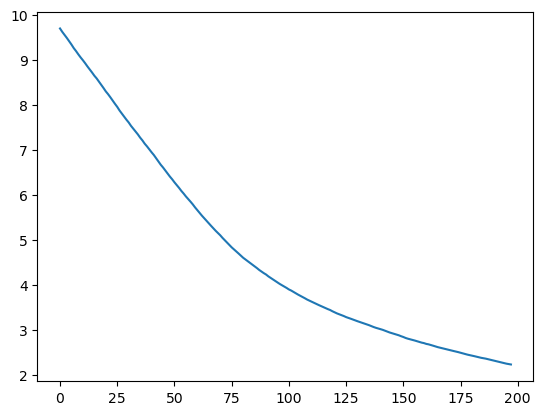

In [25]:
cumsum_vec = np.cumsum(np.insert(loss_history['total'], 0, 0)) 
print(cumsum_vec.shape)
window_width = 10
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)
plt.show()

In [26]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

X = embedding.detach().numpy()
y = bc_dataset['labels']

clf = LogisticRegression(random_state=0).fit(X, y)
y_hat = clf.predict(X)
f1_score(y, y_hat, average='micro')

c:\Users\alex_\anaconda3\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.13770364623739334